# This part(III) is mainly for Testing
# Prediction and BLEU Score

### In this notebook I will :
- Prediction
- Bleu Score
- Conclusion & Future Work
### Note : Please read the conclusion at the end.

- As the memory requirement will be more in the same file . So , I have use modules/functions from the 2nd file for testing

## Importing Required Libraries

In [1]:
import numpy as np
import os
import pandas as pd
import csv
import tensorflow.python as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import json
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding , Bidirectional , LSTM , Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Embedding, LSTM, Bidirectional, RepeatVector, TimeDistributed, Dense
import warnings
warnings.filterwarnings('ignore')

## Loading The Test Data

In [2]:
test_data_path = r'C:\Users\ayush\jupyter Notebook\NMT\data\Testing_data.csv'
test_data_path = os.path.join(test_data_path)

In [3]:
testing_data = pd.read_csv(test_data_path , encoding = 'UTF-8')
testing_data.sample(5)

,Unnamed: 0,Source,Target
801,33110,comment sest passé le vol,<start>how was the flight<end>
20547,123966,quelle differentérence cela faitil,<start>what difference does it make<end>
28566,182787,ce sera une mission très dangereuse,<start>this will be a very dangerous mission<end>
43295,166293,elle était en train de lire un manuel de jardi...,<start>she was reading a gardening manual<end>
42854,199232,il était strict dans léducation de ses enfants,<start>he was strict in disciplining his child...


## Getting maximum_common length
- This common_maximum_length is stored in the text file from the 2nd file . Now , we are using that max_length

In [4]:
## Initializing an empty variabe.
COMMON_MAXIMUM_LENGTH = None
## This file has the common_length_variable_saved.
path = r'C:\Users\ayush\jupyter Notebook\NMT\code_files\MAXIMUM_COMMON_LENGTH.txt'
## opening the file.
with open(path) as file :
    ## assigning the variable value.
    COMMON_MAXIMUM_LENGTH = int(file.read())

In [5]:
COMMON_MAXIMUM_LENGTH

55

## Importing function from nmt_module_convert_data.py to convert data into numerical sequences 

In [33]:
from NMT_convert_data import convert_data

## Separating Source and Target from the Testing Data

In [7]:
## getting source language sentences.
source = testing_data['Source']
## getting target language sentences.
target = testing_data['Target']

## Calling convert data

In [8]:
## passing the COMMON_MAX_LENGTH.
source_sequences, target_sequences, _, _, _, _, _ = convert_data(source, target, COMMON_MAXIMUM_LENGTH)

## Encoder Model

In [9]:
encoder_model = load_model(r'C:\Users\ayush\jupyter Notebook\NMT\code_files\encoder_model.keras')

In [10]:
encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, None, 100)            150100    ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  [(None, 64),                 34048     ['embedding[0][0]']           
 al)                          (None, 32),                                                         
                              (None, 32),                                                         
                              (None, 32),                                                   

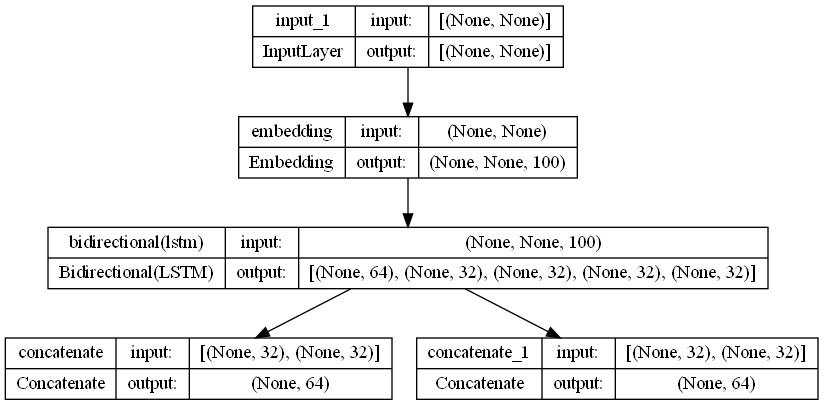

In [11]:
plot_model(encoder_model , show_shapes = True)

## Decoder Model

In [12]:
decoder_model = load_model(r'C:\Users\ayush\jupyter Notebook\NMT\code_files\decoder_model.keras')

In [13]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, None, 100)            150100    ['input_2[0][0]']             
                                                                                                  
 input_3 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                            

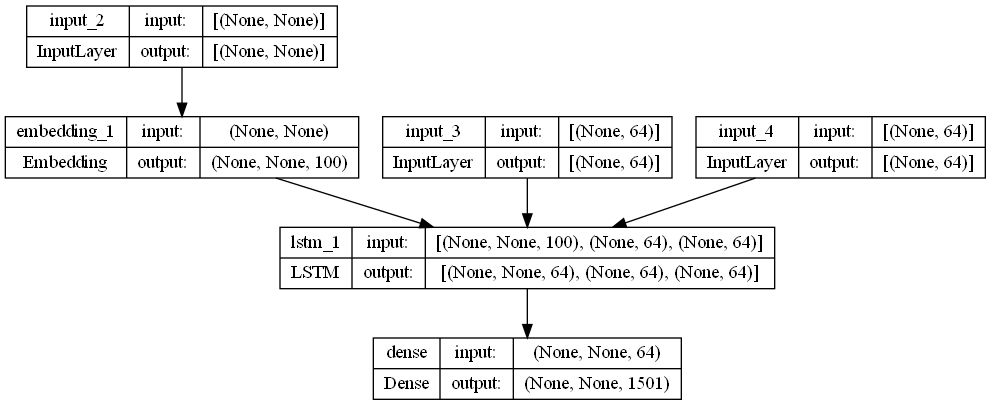

In [14]:
plot_model(decoder_model , show_shapes = True)

In [32]:
def reclean_target(sent) :
    
    '''
    This function removes 'start' and 'end' from the sentences.
    '''
    
    new_sent = sent.split()[1: -2]
    return ' '.join(new_sent)

In [16]:
testing_data['Target'] = testing_data['Target'].apply(reclean_target)
testing_data.sample(5)

,Unnamed: 0,Source,Target
27055,54485,tu as été infecté,have
20501,40352,jaime skier,am fond
20358,187793,quoi que tu fasses tu dois le faire de ton mieux,you do you must do
27597,144724,jétais lhomme le plus heureux de la terre,was the happiest man
35005,216580,soyez calmes si vous nêtes pas calmes on vous ...,quiet if you are not quiet you will be


## Prediction

In [17]:
def predicted_translation(input_seq, encoder_model, decoder_model, Target_word_index, COMMON_MAXIMUM_LENGTH):
    
    '''
    This function predicts the target output from the given input sequence.
    '''
    
    ## Predict the context vector from the encoder.
    state_values = encoder_model.predict(np.expand_dims(input_seq, axis=0)) ## coverting the 1D sequence to 2D.
    
    # Define the initial target sequence with the 'sos' token.
    target_numerical_sequence = np.zeros((1,1))
    target_numerical_sequence[0][0] = Target_word_index['start']
    
    ## define seq_len, which will work as an iterator
    seq_len = 1
    
    ## initialize the final output string
    final_translated_output = []
    
    ## boolean variable to terminate the loop
    stop_condition = False
    first = True
    
    while not stop_condition:
        
        ## Predict the next sequence and the context vector.
        output_tokens, h, c = decoder_model.predict([target_numerical_sequence] + list(state_values))
        
        # Get the predicted numerical.
        predicted_word_index = np.argmax(output_tokens[0, -1, :])
        
        if (predicted_word_index == 0) :
            break
        
        # Get the word from this predicted numerical.
        predicted_word = list(Target_word_index.keys())[list(Target_word_index.values()).index(predicted_word_index)]
        
        ## terminating condition.
        if (predicted_word == 'end' or seq_len > COMMON_MAXIMUM_LENGTH):
            stop_condition = True
            break
        
        ## add the word to the output string.
        
        final_translated_output.append(predicted_word)
        # Update the target sequence by appending the predicted_word_index.
        target_numerical_sequence[0, 0] = predicted_word_index
        seq_len += 1
        
        # Update states.
        state_values = [h, c]
        
    return ' '.join(final_translated_output)

### Importing JSON file

- That containg target_word_index

In [18]:
json_file_path = r'C:\Users\ayush\jupyter Notebook\NMT\code_files\target_word_indices.json'

# Load JSON data from the file
with open(json_file_path, 'r') as file:
    target_word_index = json.load(file)

### Predicting

- I am only predicting 10 , as it will take to much time to test all the Testing_data

In [19]:
predicted_sentences = list()
for itr in range(10) :
    predicted_sentences.append(predicted_translation(source_sequences[itr], encoder_model, decoder_model, target_word_index, COMMON_MAXIMUM_LENGTH))

1/1 [==============================] - 0s 18ms/step


In [20]:
## iterate the predicted sentences.
for itr in range(10) :
    print('Source :', source[itr])
    print('Actual Target :', testing_data['Target'][itr])
    print('Predicted Target :', predicted_sentences[itr])
    print()

Source : si vous me donnez un livre je le lirai
Actual Target : you give me a book i will
Predicted Target : if tom will give you a ride

Source : nous partirons demain si le temps le permet
Actual Target : will leave tomorrow
Predicted Target : we will take this <UKN> if we can go

Source : je suis si heureux que je mélève dans le ciel
Actual Target : am so happy i feel like i
Predicted Target : i wonder if i <UKN> in a <UKN>

Source : arrêtezvous ici 
Actual Target : 
Predicted Target : let us get here

Source : moïse descendit de la montagne en portant les commandements divins
Actual Target : came down from the mountain bearing
Predicted Target : <UKN> <UKN> <UKN> <UKN> <UKN> <UKN>

Source : je te suis reconnaissant pour ton temps
Actual Target : appreciate
Predicted Target : i am <UKN> you can

Source : que proposestu 
Actual Target : do
Predicted Target : what are you going

Source : vous avez vraiment beaucoup de chance
Actual Target : are
Predicted Target : tom wants to write yo

## 2. BLEU Score

BLEU (Bilingual Evaluation Understudy) is a metric used for evaluating the quality of machine-translated text by comparing it to one or more reference translations. It is widely used in natural language processing tasks, including machine translation.

### Components of BLEU Score
BLEU is based on precision at the n-gram level. The score is computed using the following components:

#### 1. N-gram Precision
- BLEU considers precision at different n-gram levels (unigrams, bigrams, etc.).
- Precision at each level is calculated by comparing the number of overlapping n-grams in the candidate (predicted) translation with the reference translation.

#### 2. Modified Precision
- Modified precision is used to handle the issue of short translations receiving inflated scores.
- It involves brevity penalty to penalize shorter translations.

#### 3. BLEU Score Calculation
- The overall BLEU score is calculated by combining the modified precision scores at different n-gram levels using a weighted geometric mean.
- The weights are typically set to favor shorter n-grams.

#### Implementation
- Import sentence_bleu() from NLTK
- Calculate BLEU Score.

In [24]:
from nltk.translate.bleu_score import sentence_bleu
import warnings
warnings.filterwarnings("ignore")

## Evaluating the model using BLEU score

In [25]:
def compute_bleu(actual_target_tokens, predicted_target_tokens):
    return sentence_bleu([actual_target_tokens], predicted_target_tokens)

In [26]:
# Stroring Bleu Scores for the first 10 predicted sentences.
## initialize a list.
bleu_scores = list()
## iterate first 10 predicted sentences.
for itr in range(10):
    actual_target = testing_data['Target'][itr]
    predicted_target = predicted_sentences[itr]

    # Tokenize the actual and predicted sentences
    actual_target_tokens = actual_target.split()
    predicted_target_tokens = predicted_target.split()

    # Compute BLEU score
    bleu_score = compute_bleu(actual_target_tokens, predicted_target_tokens)
    bleu_scores.append(bleu_score)

In [28]:
import matplotlib.pyplot as plt

## Function for plotting of BLEU score

In [29]:
def plot_bleu_scores(bleu_scores):
    '''
    This function plots the Bleu Score
    '''
    
    ## create the epochs array.
    epochs = np.arange(1, len(bleu_scores) + 1)

    # Plotting
    plt.figure(figsize=(6, 3))
    plt.plot(epochs, bleu_scores, linestyle='-', marker='o', color='b', label='BLEU Score')
    
    # Add labels and title
    plt.title('BLEU Score Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    
    # Add grid and legend
    plt.grid(True)
    plt.legend()
    
    # Show the plot
    plt.show()

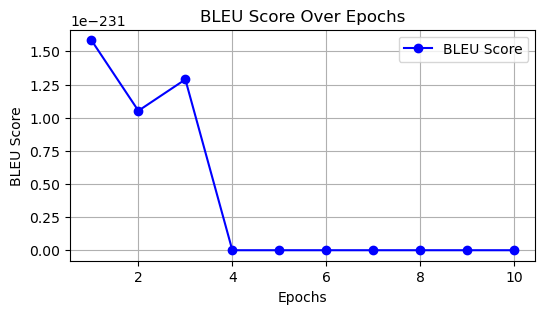

<Figure size 640x480 with 0 Axes>

In [31]:
plot_bleu_scores(bleu_scores)
## saving the plot
plt.savefig(r'C:\Users\ayush\jupyter Notebook\NMT\data\Bleu_score.png')

## 3. Conclusion & Future Work
#### Conclusion
- I have created a NMT_Module.py file, which has all the functions required in the project.
- I have followed a basic Encoder - Decoder Architecture to create the model.
- The model has been trained on less parameters, 1500 words, 10 epochs, 64 and 128 units in LSTM.
- The model has an accuracy of 70%.
#### Future Work
The future work is to :
- Create an Attention Model.
- use distributed training, to build a large model and train the model on large set of parameters.
- Use Mlops Concepts like data pipelining and Deploying the model.
- Create a WebApp using Streamlit.